<h1> Image Classification using Transfer Learning and Image Augmentation on VGG16 </h1>
Conventional machine learning techniques tries to learn features from the data. However the problem arises if the dataset is not enough to learn the features required for current Image Classification task. One solution is to use **Transfer Learning** that extracts the knowledge while solving one problem and applying it to a different but related task. Another is to augment the data so as to map the dynamics of real world. <br>The architecture used here is VGG16. Features from VGG16 are extracted and applied on our augmented dataset of Natural Scenes.

In [23]:
# necessary imports
import tensorflow as tf
from sklearn.datasets import load_files
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
from keras.utils.vis_utils import plot_model
import collections
from keras.layers import BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD, RMSprop
import keras
from keras.layers import Conv2D, Dense, MaxPool2D, Flatten, Dropout, Activation
from keras.models import Sequential
import os
import sys
from keras.utils.vis_utils import plot_model
import datetime
import glob as glob
import numpy as np
import cv2
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
import tensorflow
import pandas as pd
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline

<h2> Load Dataset </h2>
Here we will download the Dataset of Natural Scene from kaggel intel-image-classification and unzip it in local colab directory <br><br>

In [2]:
#Uploading kaggle.json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aamna27","key":"9944f09a800fd209ebde42468fb6f834"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d puneet6060/intel-image-classification

 97% 335M/346M [00:02<00:00, 174MB/s]
100% 346M/346M [00:02<00:00, 175MB/s]


In [ ]:
!unzip intel-image-classification.zip -d Dataset
!rm -rf /content/intel-image-classification.zip

In [ ]:
!rm -rf /content/Dataset/seg_pred
!unzip Test_data.zip -d Dataset

In [8]:
train_dir = 'Dataset/seg_train/seg_train'
validate_dir = 'Dataset/seg_test/seg_test'
test_dir = 'Dataset/seg_pred/seg_pred'

batch_size = 32
nb_classes = len(glob.glob(train_dir + '/*'))

# get number of images in training directory
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
    for dr in dirs:
        nb_train_samples += len(glob.glob(os.path.join(r, dr + "/*")))
# get number of images in validation directory
nb_validate_samples = 0
for r, dirs, files in os.walk(validate_dir):
    for dr in dirs:
        nb_validate_samples += len(glob.glob(os.path.join(r, dr + "/*")))

nb_test_samples = 0
for r, dirs, files in os.walk(test_dir):
    for dr in dirs:
        nb_test_samples += len(glob.glob(os.path.join(r, dr + "/*")))

<h2> Data Augmentation </h2>
Data preparation is almost always required when working with any data analysis, machine learning, neural network or deep learning models. It becomes even more important to augment data in the case of image recognition. Keras provides the ImageDataGenerator class that defines the configuration for image data preparation and augmentation

In [9]:

nb_epochs = 20
batch_size = 32
# data pre-processing for training
train_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 10,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    # zoom_range = 0.5,
    fill_mode = 'nearest',
    horizontal_flip = True)

# data pre-processing for validation
validate_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 10,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    # zoom_range = 0.5,
    fill_mode = 'nearest',
    horizontal_flip = True)
# data pre-processing for validation
test_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 15,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.15,
    # zoom_range = 0.5,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [12]:
# generate and store training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (32, 32),
    batch_size = batch_size)

# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size = (32, 32),
    batch_size = batch_size)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (32, 32),
    batch_size = batch_size)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7301 images belonging to 6 classes.


<h2>VGG16 Architecture</h2>

Instead of 2242243, input shape of 32323 has been used. Apart from last four layers rest of the layers of VGG16 Architecture are frozen. A convolution layer and Relu activation is added with GlobalAveragePooling at the end. This sequence is followed by one fully connected layer and Softmax Function

In [10]:
def vgg_tl_aug(OPTIMIZER, LEARN_RATE, DECAY, MOMEMTUM, EPOCHS):
    trained_model = VGG16(include_top=False,weights='imagenet')
    x = trained_model.output
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    pred_vgg= Dense(6,activation='softmax')(x)
    model = Model(inputs=trained_model.input,outputs=pred_vgg)
    print(trained_model.layers)
    for layer in trained_model.layers[:4]:
        layer.trainable=(False)
    if OPTIMIZER == "Adam":
      print(OPTIMIZER)
      LEARN_RATE = 0.001/EPOCHS 
      adam = Adam(lr=LEARN_RATE)
      model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=adam)
    if OPTIMIZER == "SGD":
      print(OPTIMIZER)
      LEARN_RATE = 0.001/EPOCHS 
      sgd = SGD(lr=LEARN_RATE, decay=0, momentum=0.9)
      model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=sgd)
    if OPTIMIZER == "RMS":

      print(OPTIMIZER)
      LEARN_RATE = 0.001/EPOCHS 
      rms = RMSprop(lr=LEARN_RATE)
      model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=rms)

    return(model)

[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fc2d7f41cf8>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc3ec226ef0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc3ec225f28>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc3ec2b6208>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc3ec2b6eb8>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc3ec2aee10>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc3ec2ae710>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc3ec293be0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc3ec2930b8>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc3fe320ef0>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc3ec2b16a0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc3ec2b1c50>, <tensorflow.python.keras.layers.convo

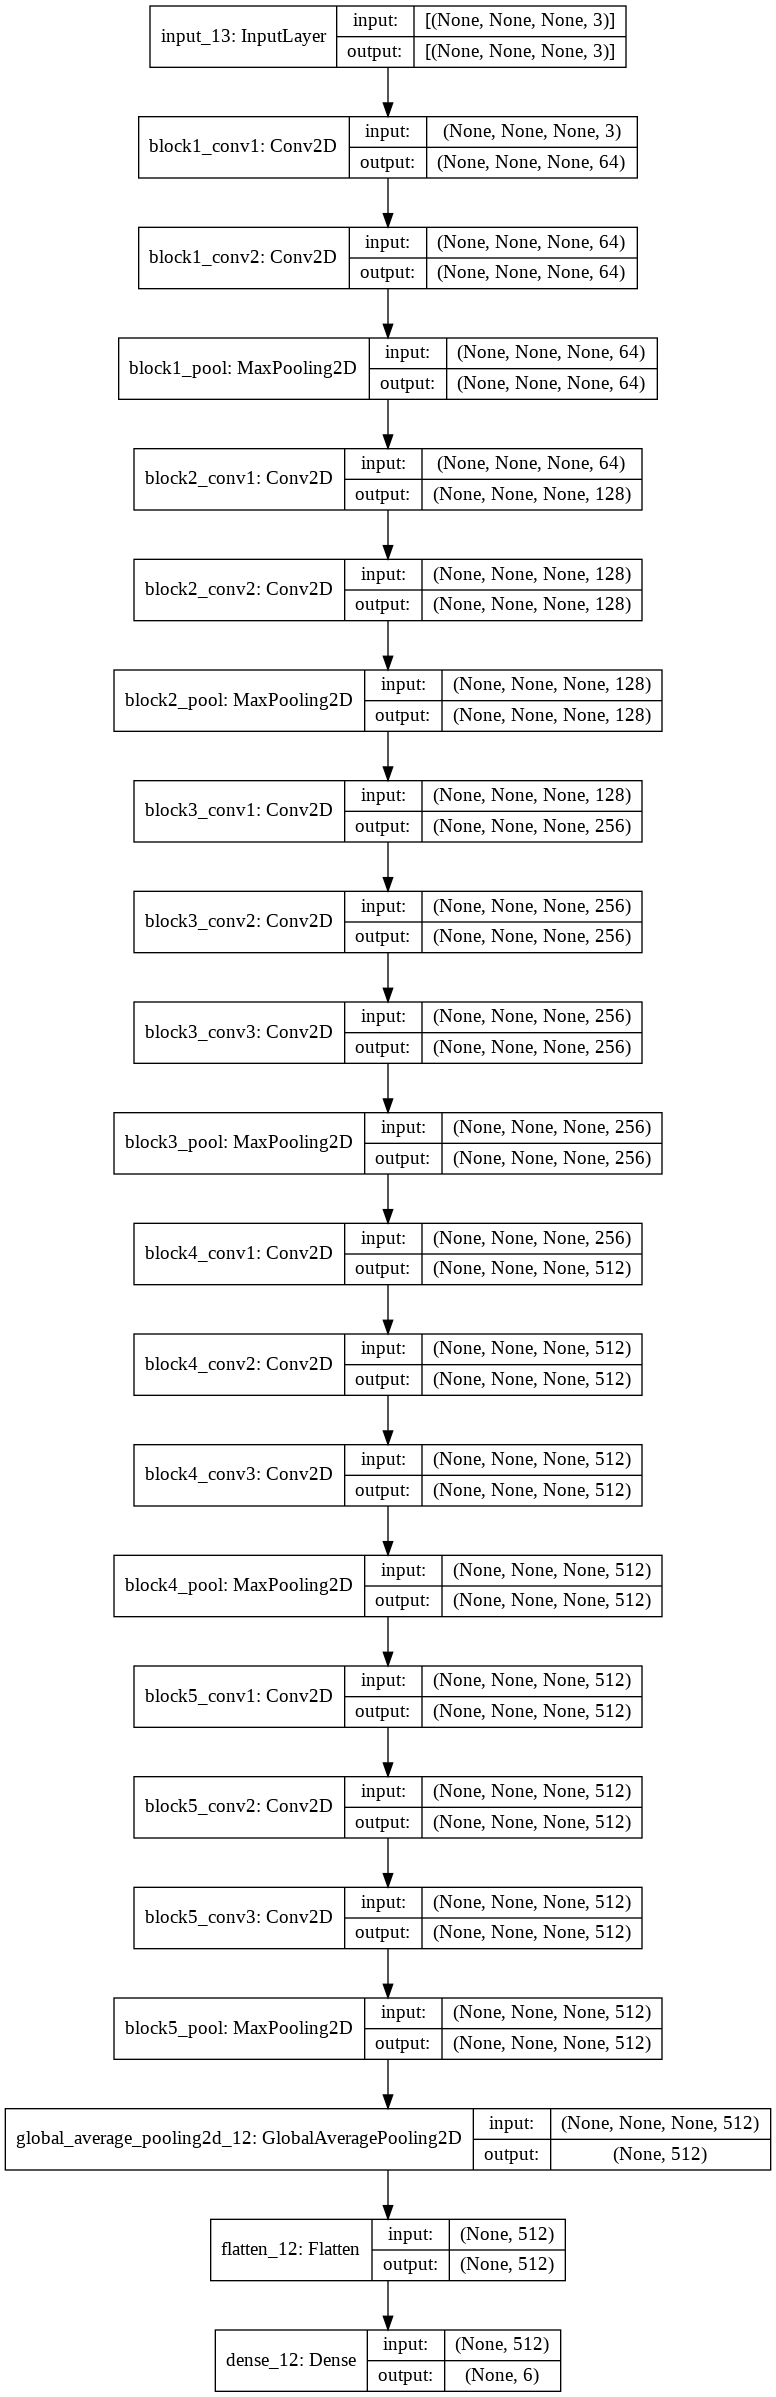

In [25]:

vgg_model_pic = vgg_tl_aug("Adam", DECAY= 1e-7, MOMEMTUM = 0.9, LEARN_RATE =0.001, EPOCHS =75)
plot_model(vgg_model_pic, to_file='Results/VGG-TL-model.png', show_shapes=True)

Making dictionary to store results of experiments

In [11]:

all_acc_dict = collections.OrderedDict()
accdict = {}

<h2> Compile and Train the Model </h2>
Using different choices of optimizers, the model is being trained. **Early Stopping** is being used to tackle number of epochs. Each time a better validation accuracy is achieved the model weights are updated in the directory.


In [13]:

es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('CheckPoints/VGG16-TL-Aug-model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

def training(BATCH_SIZE, EPOCHS, OPTIMIZER, LEARN_RATE, DECAY = 0, MOMEMTUM = 0 ):
  accdict = {}
  vgg_model = vgg_tl_aug(OPTIMIZER, DECAY, MOMEMTUM, LEARN_RATE, EPOCHS)
  H = vgg_model.fit_generator(
    train_generator,
    epochs = EPOCHS,
    # samples_per_epoch = nb_train_samples,
    validation_data = validate_generator,
    callbacks=[es,mc])
  trainacc = H.history['accuracy']
  valacc = H.history['val_accuracy']
  trainloss = H.history['loss']
  valloss = H.history['val_loss']
  score = vgg_model.evaluate_generator(test_generator)
  accdict["trainacc"] =trainacc[len(trainacc)-1]
  accdict["trainloss"] =trainloss[len(trainloss)-1]
  accdict["valacc"] = valacc[len(valacc)-1]
  accdict["valloss"] = valloss[len(valloss)-1]
  accdict["testacc"] = score[1]
  accdict["testloss"] = score[0]
  
  return H, accdict

In [14]:

History1, all_acc_dict["Adam_Exp1"] = training(32, 75, "Adam", 0.001)

History2, all_acc_dict["Adam_Exp2"] = training(64, 75, "Adam", 0.001)
History3, all_acc_dict["Adam_Exp3"] = training(128, 75,"Adam", 0.001) 
History4, all_acc_dict["SGD_Exp1"] = training(32, 75, "SGD", 0.001)

History5, all_acc_dict["SGD_Exp2"] = training(64, 60, "SGD", 0.001)
History6, all_acc_dict["SGD_Exp3"] = training(128, 60,"SGD", 0.001) 
History7, all_acc_dict["RMS_Exp1"] = training(32, 60, "RMS", 0.001)

History8, all_acc_dict["RMS_Exp2"] = training(64, 75, "RMS", 0.001)
History9, all_acc_dict["RMS_Exp3"] = training(128, 75,"RMS", 0.001) 

58892288/58889256 [==============================] - 1s 0us/step
[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fc4c0180518>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc4b3bee908>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc4669acf98>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc466985860>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc4664be908>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc4664be9b0>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc4664c2ef0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc4664c8ba8>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc4664cedd8>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc4664ce048>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc4664d49e8>, <tensorflow.python.keras.layers.convolutional.Conv2D

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/75
439/439 [==============================] - 32s 57ms/step - loss: 1.0058 - accuracy: 0.6202 - val_loss: 0.6041 - val_accuracy: 0.7843

Epoch 00001: val_accuracy improved from -inf to 0.78433, saving model to CheckPoints/best_model.h5
Epoch 2/75
439/439 [==============================] - 24s 54ms/step - loss: 0.5735 - accuracy: 0.7926 - val_loss: 0.6009 - val_accuracy: 0.7830

Epoch 00002: val_accuracy did not improve from 0.78433
Epoch 3/75
439/439 [==============================] - 23s 53ms/step - loss: 0.5113 - accuracy: 0.8122 - val_loss: 0.5535 - val_accuracy: 0.7937

Epoch 00003: val_accuracy improved from 0.78433 to 0.79367, saving model to CheckPoints/best_model.h5
Epoch 4/75
439/439 [==============================] - 24s 54ms/step - loss: 0.4980 - accuracy: 0.8177 - val_loss: 0.5344 - val_accuracy: 0.8040

Epoch 00004: val_accuracy improved from 0.79367 to 0.80400, saving model to CheckPoints/best_model.h5
Epoch 5/75
439/439 [==============================] - 23s 53ms

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fc4c21e2630>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc4664ddb70>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc450073f60>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc40e3e09b0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc40e3e07b8>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc4664efd30>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc40e3e0b70>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc40e3e05c0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc40e403fd0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc4664f2390>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fc40e3f0400>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fc40e48d8d0>, <tensorflow.python.keras.layers.convo

<h2> Evaluate the Model </h2>
Model is evaluated on the weights that produced the highest validation accuracy. These weights were stored during training.


In [19]:

saved_model = load_model('CheckPoints/VGG16-TL-Aug-model.h5')
# evaluate the model
_, train_acc = saved_model.evaluate_generator(train_generator, verbose=0)
_, val_acc = saved_model.evaluate_generator(validate_generator, verbose=0)
_, test_acc = saved_model.evaluate_generator(test_generator, verbose=0)
print('Train: %.3f,Val: %.3f, Test: %.3f' % (train_acc, val_acc,  test_acc))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Train: 0.925,Val: 0.849, Test: 0.837


<h2> Plotting Training and Validation accuracy of different optimizers </h2>

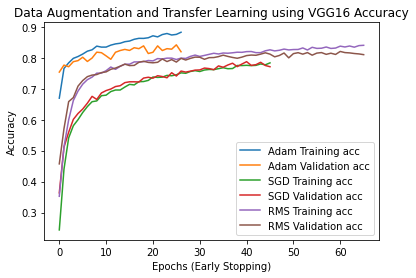

In [32]:

History =0
History = History2
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']

epochs = range(len(acc))
plt.xlabel('Epochs (Early Stopping)')
plt.ylabel('Accuracy')
plt.title('Data Augmentation and Transfer Learning using VGG16 Accuracy')

plt.plot(epochs, acc, label='Adam Training acc')
plt.plot(epochs, val_acc, label='Adam Validation acc')

History =0
History = History4
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, label='SGD Training acc')
plt.plot(epochs, val_acc, label='SGD Validation acc')



History =0
History = History7
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, label='RMS Training acc')
plt.plot(epochs, val_acc, label='RMS Validation acc')
plt.legend()
plt.savefig("DataAugTLVGG16Historyacc.png")



<h2> Plotting Training and Validation losses of different optimizers </h2>

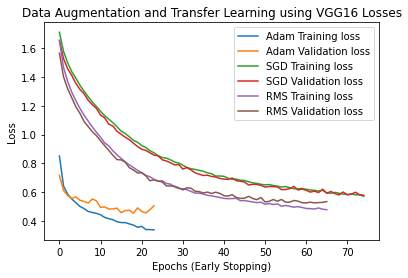

In [33]:

History =0
History = History3
loss = History.history['loss']
val_loss = History.history['val_loss']

epochs = range(len(loss))
plt.xlabel('Epochs (Early Stopping)')
plt.ylabel('Loss')
plt.title('Data Augmentation and Transfer Learning using VGG16 Losses')

plt.plot(epochs, loss, label='Adam Training loss')
plt.plot(epochs, val_loss, label='Adam Validation loss')

History =0
History = History5
loss = History.history['loss']
val_loss = History.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, label='SGD Training loss')
plt.plot(epochs, val_loss, label='SGD Validation loss')



History =0
History = History7
loss = History.history['loss']
val_loss = History.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, label='RMS Training loss')
plt.plot(epochs, val_loss, label='RMS Validation loss')
plt.legend()
plt.savefig("Results/DataAugTLVGG16Historyloss.png")



Printing accuracies and losses of experiments



In [20]:

for k, v in all_acc_dict.items():
    trainacc, trainloss, valacc, valloss,testacc, testloss = v
    print(v)
    print( "".format(k, trainacc, trainloss, valacc, valloss,testacc, testloss ))

{'trainacc': 0.9154909253120422, 'trainloss': 0.2259276956319809, 'valacc': 0.8433333039283752, 'valloss': 0.49158892035484314, 'testacc': 0.8212573528289795, 'testloss': 0.6288571357727051}

{'trainacc': 0.9101467728614807, 'trainloss': 0.24455232918262482, 'valacc': 0.8433333039283752, 'valloss': 0.4689033329486847, 'testacc': 0.8252294063568115, 'testloss': 0.5793375968933105}

{'trainacc': 0.9013823866844177, 'trainloss': 0.26563960313796997, 'valacc': 0.8360000252723694, 'valloss': 0.4686993956565857, 'testacc': 0.8383783102035522, 'testloss': 0.5541751980781555}

{'trainacc': 0.8481544852256775, 'trainloss': 0.41402849555015564, 'valacc': 0.8273333311080933, 'valloss': 0.49085941910743713, 'testacc': 0.8172852993011475, 'testloss': 0.5194311141967773}

{'trainacc': 0.8440929055213928, 'trainloss': 0.4259345829486847, 'valacc': 0.8236666917800903, 'valloss': 0.4992027282714844, 'testacc': 0.821668267250061, 'testloss': 0.5099269151687622}

{'trainacc': 0.8385350108146667, 'trainlo

<h2> Predict on Unseen Images </h2>


In [26]:

saved_model = load_model('CheckPoints/VGG16-TL-Aug-model.h5')
predY = saved_model.predict_generator(test_generator)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


<h2> Confusion Matrix </h2>

In [28]:

predY_classes = predY.argmax(1)
confusion_matrix = pd.crosstab(test_generator.classes, predY_classes,margins=True)
print("Confusion matrix:\n%s" % confusion_matrix)

Confusion matrix:
col_0     0     1     2     3     4     5   All
row_0                                          
0       183   182   191   201   200   187  1144
1       191   179   192   219   199   186  1166
2       197   250   209   236   204   234  1330
3       212   222   208   241   216   198  1297
4       170   203   165   218   189   183  1128
5       181   180   226   252   197   200  1236
All    1134  1216  1191  1367  1205  1188  7301


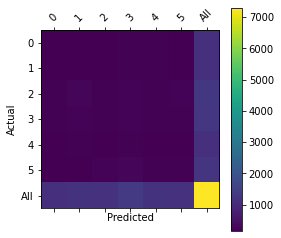

In [30]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.YlOrRd):
  plt.matshow(df_confusion) # imshow
  plt.colorbar()
  tick_marks = np.arange(len(df_confusion.columns))
  plt.xticks(tick_marks, df_confusion.columns, rotation=45)
  plt.yticks(tick_marks, df_confusion.index)
  plt.ylabel("Actual")
  plt.xlabel("Predicted")
  plt.savefig("Results/DataAugTLVGG16Augconfusion.jpg")
#call function
plot_confusion_matrix(confusion_matrix)